# Clustering Model
This notebook contains a clustering model of the artists and song lyrics. 


In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import re
from bs4 import BeautifulSoup             
import squarify
from yellowbrick.cluster import InterclusterDistance

import spacy
from spacy.lang.en import English
import en_core_web_lg
from spacy import displacy


In [2]:
lyrics = pd.read_csv('./all_lyrics.csv')
lyrics.head()

,artist_name,lyrics,billboard_genre,clean_lyrics
0,Selena Gomez,You promised the world and I fell for it\nI pu...,pop,you promised the world and i fell for it i put...
1,​The Lumineers,"Ah, ah, when I was younger\nI, I should've kno...",folk_americana,ah ah when i was younger i i should ve known b...
2,Simon & Garfunkel,"Hello darkness, my old friend\nI've come to ta...",folk_americana,hello darkness my old friend i ve come to talk...
3,Mumford & Sons,Heto mi halanma\nMine waddimi yiddema\nKo ane ...,folk_americana,heto mi halanma mine waddimi yiddema ko ane ta...
4,Lord Huron,I am not the only traveler\nWho has not repaid...,folk_americana,i am not the only traveler who has not repaid ...


In [3]:
#Add a new column to the df that counts unique words of a song

def unique_words(df):
    word_count = [len(set(df['clean_lyrics'].values[i].split())) for i in range(0,df.shape[0])] 

    return word_count

#Create new column in df called unique_words
lyrics.loc[:, ('unique_words')] = unique_words(lyrics)

In [4]:
#get char count
lyrics['length'] = [len(lyric) for lyric in lyrics['clean_lyrics']]

## Preprocess The Data Using spaCy

In [5]:
nlp = en_core_web_lg.load()

In [6]:
nlp.max_length = 1019400 #increase the max length to handle lyrics that exceed count of 1_000_000

In [7]:
#lemmatize the lyrics
lyrics['clean_lyrics'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row) if w.lemma_ != '-PRON-']))

# solution adapted from https://stackoverflow.com/questions/47498293/how-can-i-lemmatize-strings-in-pandas-dataframes

0     promise the world and i fall for i put first a...
1     ah ah when i be young i i should ve know well ...
2     hello darkness old friend i ve come to talk wi...
3     heto mi halanma mine waddimi yiddema ko ane ta...
4     i be not the only traveler who have not repay ...
5     don t know i m no good for i ve learn to lose ...
6     i be scare of dentist and the dark i be scared...
7     old man look at life i m a lot like be old man...
8     thought i d end up with sean but wasn t a matc...
9     woo should take this back to place that s what...
10    i wanna follow where go i think about and know...
11    hey i be do just fine before i meet i drink to...
12    first thing first i ma say all the word inside...
13    when rain pour but didn t even notice ain t ra...
14    hahahahaha tank god ayy ayy i ve be fuckin hoe...
15    be travel these wide road for so long heart s ...
16    lover s get humor s the giggle at a funeral kn...
17    hey havana ooh na na ayy half of heart be 

### Preprocessing
Compare the output between CountVectorizer and TfIfdVectorizer

In [8]:
#instantiate
cv = CountVectorizer(stop_words='english', ngram_range=(1,3))

#fit transform
cv_vec = cv.fit_transform(lyrics['clean_lyrics'])

#create a dataframe
cv_df = pd.DataFrame(cv_vec.todense(), columns=cv.get_feature_names())

In [9]:
#TF-IDF
tf = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tf_vec = tf.fit_transform(lyrics['clean_lyrics'])

#create a dataframe
tf_df = pd.DataFrame(tf_vec.todense(), columns=tf.get_feature_names())

# Use K-means to cluster

In [10]:
#cluster using the lemmatized words and countvectorizer

#intstantiate model
km_cv = KMeans(n_clusters=5, random_state=42)
km_cv.fit(cv_vec)

#create a column called cluster
lyrics['cluster_cv'] = km_cv.labels_

In [11]:
#Silhouette_score
silhouette_score(cv_vec, km_cv.labels_)

0.20236548608009444

In [12]:
#cluster using the lemmatized words and tf-idfvectorizer

#intstantiate model
km_tf = KMeans(n_clusters=5, random_state=42)
km_tf.fit(tf_vec)

#create a column called cluster
lyrics['cluster_tf'] = km_tf.labels_

In [13]:
#Silhouette_score
silhouette_score(tf_vec, km_tf.labels_)

0.010897229851075645

In [14]:
lyrics.sort_values('cluster_cv')

,artist_name,lyrics,billboard_genre,clean_lyrics,unique_words,length,cluster_cv,cluster_tf
28,Drake,And they wishin' and wishin' and wishin' and w...,pop,and they wishin and wishin and wishin and wish...,10327,1019350,0,3
18,Panic! at the Disco,"High, high hopes\n\nHad to have high, high hop...",pop,high high hopes had to have high high hopes fo...,3214,211713,1,1
31,Charlie Puth,"Woah-oh, hm-hmm\n\nYou've been runnin' 'round,...",pop,woah oh hm hmm you ve been runnin round runnin...,2065,209974,1,3
30,Bruno Mars,"Hey, hey, hey\nI got a condo in Manhattan\nBab...",pop,hey hey hey i got a condo in manhattan baby gi...,1927,182161,1,3
29,Halsey,Found you when your heart was broke\nI filled ...,pop,found you when your heart was broke i filled y...,2915,205962,1,3
26,James Taylor,"Just yesterday morning, they let me know you w...",folk_americana,just yesterday morning they let me know you we...,4219,272667,1,2
19,Alessia Cara,I guess right now you've got the last laugh\n\...,pop,i guess right now you ve got the last laugh i ...,1712,150879,1,3
17,Camila Cabello,"Hey\n\nHavana, ooh na-na (Ayy)\nHalf of my hea...",pop,hey havana ooh na na ayy half of my heart is i...,1860,138914,1,3
12,Imagine Dragons,First things first\nI'ma say all the words ins...,pop,first things first i ma say all the words insi...,2761,282041,1,1
11,The Chainsmokers,"Hey, I was doing just fine before I met you\nI...",pop,hey i was doing just fine before i met you i d...,1197,211175,1,3


# How close are the clusters?
Intercluster distance maps display an embedding of the cluster centers in 2 dimensions with the distance to other centers preserved. E.g. the closer to centers are in the visualization, the closer they are in the original feature space. The clusters are sized according to a scoring metric. By default, they are sized by membership, e.g. the number of instances that belong to each center. This gives a sense of the relative importance of clusters. Note however, that because two clusters overlap in the 2D space, it does not imply that they overlap in the original feature space.

Source: https://www.scikit-yb.org/en/latest/api/cluster/icdm.html?highlight=intercluster

#### Intercluster Distance Map based on CountVectorizer

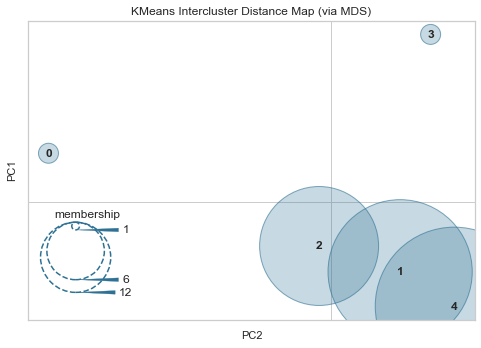

In [15]:
# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(km_cv)

visualizer.fit(lyrics)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure


From here we can infer Drake (0) has lyrics that are vastly different from the rest of the artists.

Selena Gomez (3) also has lyrics that appear different from the rest of the artists.

#### Intercluster Distance Map based on TF-IDFVectorizer

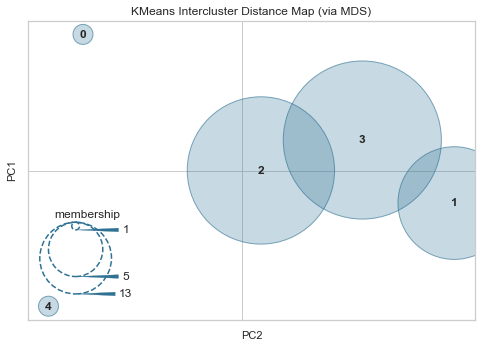

In [16]:
# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(km_tf)

visualizer.fit(lyrics)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure


From here we can infer Simon & Garfunkal (4) and Chris Stapleton (0) have lyrics that are vastly different from the rest of the artists. I am skeptical about this cluster, so will choose to use CountVectorizer in further analysis

In [17]:
lyrics[lyrics['cluster_tf'] == 4]

,artist_name,lyrics,billboard_genre,clean_lyrics,unique_words,length,cluster_cv,cluster_tf
2,Simon & Garfunkel,"Hello darkness, my old friend\nI've come to ta...",folk_americana,hello darkness my old friend i ve come to talk...,2616,122125,4,4


In [18]:
lyrics[lyrics['cluster_tf'] == 0]

,artist_name,lyrics,billboard_genre,clean_lyrics,unique_words,length,cluster_cv,cluster_tf
21,Chris Stapleton,Used to spend my nights out in a barroom\nLiqu...,folk_americana,used to spend my nights out in a barroom liquo...,1202,45170,4,0


# How similar are the lyrics of the top artists for each genre?

In [20]:
def plot_clusters_artists(genre, genre_title):
    df = pd.DataFrame(lyrics[lyrics['billboard_genre'] == genre][['cluster_cv']].value_counts().reset_index())
    
    squarify.plot(sizes=df[0], label=df['cluster_cv'], alpha=.7,color=['lightcyan','lightgreen','yellow','grey','orange'])
    plt.axis('off')
    plt.title(f'Percentage of Clusters for {genre_title} Artists', size=16)
    plt.show()

    return None

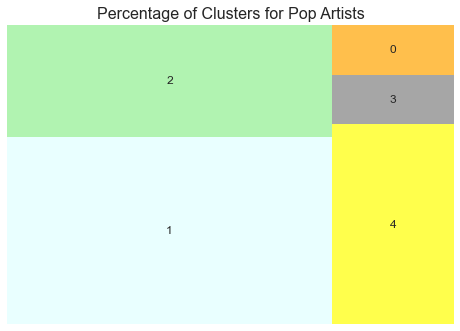

<Figure size 576x396 with 0 Axes>

In [21]:
plot_clusters_artists('pop','Pop')
plt.savefig('./imgs/pop_cluster.jpeg',bbox_inches='tight');

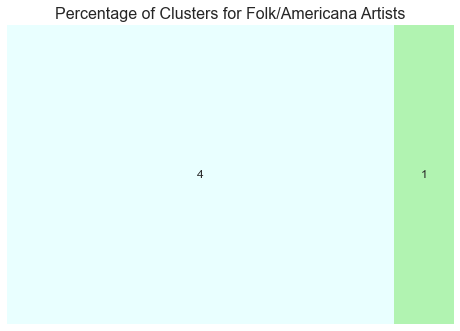

<Figure size 576x396 with 0 Axes>

In [22]:
plot_clusters_artists('folk_americana', 'Folk/Americana')
plt.savefig('./imgs/folk_cluster.jpeg',bbox_inches='tight');

### Look at Similarity using spaCy

In [111]:
#create lists to store values
comparisons = []
scores = []

#loop through and compare each combination of artist
for i in range(0, lyrics.shape[0]):
    for _ in range(0,lyrics.shape[0]):
        comparisons.append(f"{lyrics['artist_name'][i]} compared to {lyrics['artist_name'][_]}")
        scores.append((nlp(lyrics['clean_lyrics'][i])).similarity(nlp(lyrics['clean_lyrics'][_])))

In [113]:
artist_similarity = pd.DataFrame({
    'comparison': comparisons,
    'scores': scores
})

In [120]:
# Top 3 Most Similar Artists
artist_similarity[artist_similarity['scores'] < 1.0].sort_values('scores', ascending=False).head(6)

,comparison,scores
935,Maroon 5 compared to Shawn Mendes,0.999329
395,Shawn Mendes compared to Maroon 5,0.999329
961,Maroon 5 compared to Jonas Brothers,0.999054
1357,Jonas Brothers compared to Maroon 5,0.999054
381,Shawn Mendes compared to The Chainsmokers,0.999037
417,The Chainsmokers compared to Shawn Mendes,0.999037


In [119]:
# Top 3 Most Non-Similar Artists
artist_similarity[artist_similarity['scores'] < 1.0].sort_values('scores', ascending=True).head(6)

,comparison,scores
525,Post Malone compared to Neil Young,0.975826
273,Neil Young compared to Post Malone,0.975826
282,Neil Young compared to Lizzo,0.979234
858,Lizzo compared to Neil Young,0.979234
125,Mumford & Sons compared to Post Malone,0.979630
521,Post Malone compared to Mumford & Sons,0.979630


# Cluster John Mayer's songs

In [38]:
songs = pd.read_csv('./all_songs.csv')

In [39]:
#create a dataframe of just John Mayer songs
john_mayer = songs[songs['artist_name'] == 'John Mayer']
john_mayer.head()

,artist_name,image_url,url,title,lyrics,spotify_url,billboard_genre,clean_lyrics
2730,John Mayer,https://images.genius.com/4c443bf06bf6b696ad4f...,https://genius.com/artists/John-mayer,New Light,"Ah, ah, ah\nAh...\n\nI'm the boy in your other...",https://open.spotify.com/track/3bH4HzoZZFq8UpZ...,folk_americana,ah ah ah ah i m the boy in your other phone li...
2731,John Mayer,https://images.genius.com/4c443bf06bf6b696ad4f...,https://genius.com/artists/John-mayer,Gravity,Gravity is working against me\nAnd gravity wan...,https://open.spotify.com/track/52K3qt1rCYf3Ciu...,folk_americana,gravity is working against me and gravity want...
2732,John Mayer,https://images.genius.com/4c443bf06bf6b696ad4f...,https://genius.com/artists/John-mayer,Slow Dancing in a Burning Room,It's not a silly little moment\nIt's not the s...,https://open.spotify.com/track/3f8Uygfz3CIpUCo...,folk_americana,it s not a silly little moment it s not the st...
2733,John Mayer,https://images.genius.com/4c443bf06bf6b696ad4f...,https://genius.com/artists/John-mayer,Free Fallin’,"She's a good girl, loves her mama\nLoves Jesus...",https://open.spotify.com/track/4LloVtxNZpeh7q7...,folk_americana,she s a good girl loves her mama loves jesus a...
2734,John Mayer,https://images.genius.com/4c443bf06bf6b696ad4f...,https://genius.com/artists/John-mayer,In the Blood,How much of my mother has my mother left in me...,https://open.spotify.com/track/77Y57qRJBvkGCUw...,folk_americana,how much of my mother has my mother left in me...


In [58]:
#Create new column in df called unique_words
john_mayer.loc[:, ('unique_words')] = unique_words(john_mayer)

In [126]:
#get char count
john_mayer.loc[:, 'length'] = [len(lyric) for lyric in john_mayer['clean_lyrics']]

In [67]:
#instantiate and fit 
cv_jm = CountVectorizer(stop_words='english', ngram_range=(1,3))
lyrics_vec_jm = cv_jm.fit_transform(john_mayer['clean_lyrics'])

In [68]:
#intstantiate model
km_jm = KMeans(n_clusters=3, random_state=42)
km_jm.fit(lyrics_vec_jm)


KMeans(n_clusters=3, random_state=42)

In [69]:
#Silhouette_score
silhouette_score(lyrics_vec_jm, km_jm.labels_)

0.7083572300984751

In [71]:
john_mayer.loc[:, ('cluster')] = km_jm.labels_

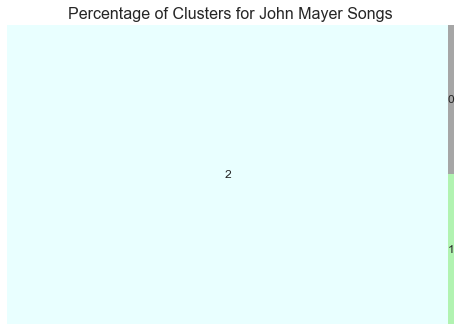

In [72]:
df_john_mayer = pd.DataFrame(john_mayer[['cluster']].value_counts(normalize=True).reset_index())

squarify.plot(sizes=df_john_mayer[0], label=df_john_mayer['cluster'], alpha=.7, color=['lightcyan','lightgreen','grey'])
plt.axis('off')
plt.title(f'Percentage of Clusters for John Mayer Songs', size=16)
plt.savefig('./imgs/john_mayer_cluster.jpeg',bbox_inches='tight');

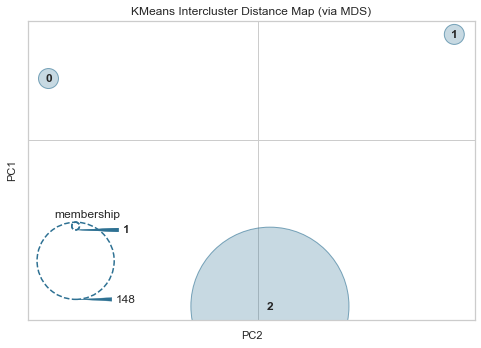

In [74]:
# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(km_jm)

visualizer.fit(john_mayer)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure


In [75]:
#what is cluster 1?
john_mayer[john_mayer['cluster'] == 0]

,artist_name,image_url,url,title,lyrics,spotify_url,billboard_genre,clean_lyrics,cluster,unique_words,length
2767,John Mayer,https://images.genius.com/4c443bf06bf6b696ad4f...,https://genius.com/artists/John-mayer,Say,Take all of your wasted honor\nEvery little pa...,NaN,folk_americana,take all of your wasted honor every little pas...,0,78,1549


In [76]:
#what is cluster 2?
john_mayer[john_mayer['cluster'] == 1]

,artist_name,image_url,url,title,lyrics,spotify_url,billboard_genre,clean_lyrics,cluster,unique_words,length
2855,John Mayer,https://images.genius.com/4c443bf06bf6b696ad4f...,https://genius.com/artists/John-mayer,Wanna Be Startin’ Somethin’,I said you want to be starting something\nYou ...,NaN,folk_americana,i said you want to be starting something you g...,1,142,4185


It would make sense that "Wanna Be Startin' Somethin'" is in this list because it is not an original John Mayer song. "Say" repeats the same lyrics for the whole song, which is why I believe this ended up in it's own cluster.